In [1]:
%load_ext rpy2.ipython

In [3]:
%%R
library(tidyverse)
library(ggpubr)
library(phyloseq)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [4]:
%%R
source("R/config.R")
source("R/theme.R")

### taxonomic profile

In [5]:
%%R
tax_p <-
    read_tsv("data/metaphlan3.merged.abundance.profile.phylum.272S.tsv") %>%
    column_to_rownames("clade_name")

tax_s <-
    read_tsv("data/metaphlan3.merged.abundance.profile.species.272S.tsv") %>%
    column_to_rownames("clade_name")

Rows: 12 Columns: 273
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr   (1): clade_name
dbl (272): VAC003B-M1_S2, VAC005B-M1_S3, VAC007B-M1_S4, VAC010B-M1_S5, VAC01...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 547 Columns: 273
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr   (1): clade_name
dbl (272): VAC003B-M1_S2, VAC005B-M1_S3, VAC007B-M1_S4, VAC010B-M1_S5, VAC01...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### metadata

In [6]:
%%R
metadata <- read_tsv("metadata/samples_metadata_imm_272S.tsv") %>% data.frame()
rownames(metadata) <- metadata$sample_id

Rows: 272 Columns: 57
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (7): sample_id, ID, TimePoint, Cohort, Vac_Group, Dose1_AE_num_cat, Dos...
dbl (50): all_bray_cluster3, Age, Male, BMI, OWOB, Obese_bin, HTC_bin, DMC_b...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### combine profile and metadata at D0

In [7]:
%%R

tax_s_d0_w <- 
    tax_s %>%
    rownames_to_column("clade_name") %>%
    rowwise() %>%
    mutate(Species=str_split(clade_name, "\\|s__")[[1]][2]) %>%
    select(-clade_name) %>%
    pivot_longer(names_to="sample_id", values_to="Abundance", -Species) %>%
    pivot_wider(names_from="Species", values_from="Abundance") %>%
    right_join(metadata %>% filter(TimePoint=="D0"))

Joining, by = "sample_id"


In [ ]:
%%R
write_csv(tax_s_d0_w, "tables/species_profile_with_metadata.csv")
write_tsv(tax_s_d0_w, "tables/species_profile_with_metadata.tsv")

### phyloseq object

In [11]:
%%R
tax_s_pls <- phyloseq(otu_table(tax_s, taxa_are_rows=TRUE),
                      sample_data(metadata))
tax_p_pls <- phyloseq(otu_table(tax_p, taxa_are_rows=TRUE),
                      sample_data(metadata))

In [12]:
%%R
source("R/alpha_diversity.R")

### alpha diversity

In [13]:
%%R
species_diver_all <- alpha_diversity(tax_s_pls, method = "all")

dim(species_diver_all)

R[write to console]: observed

R[write to console]: Observed richness

R[write to console]: Other forms of richness

R[write to console]: Diversity

R[write to console]: Evenness

R[write to console]: Dominance

R[write to console]: Rarity

R[write to console]: simpson

R[write to console]: shannon

R[write to console]: all



Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(sample_varname)` instead of `sample_varname` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.
Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(group_varname)` instead of `group_varname` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.
Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(time_varname)` instead of `time_varname` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.
Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(pairID_varname)` instead of `pairID_varname` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This messa

In [ ]:
%%R
write_tsv(species_diver_all, "tables/alpha_diversity/alpha_diversity.tsv")

In [17]:
%%R
species_diver_all <-
    species_diver_all %>%
    rename(sample_id = sample) %>%
    left_join(metadata) %>% arrange(Cohort, Vac_Group, ID) %>%
    mutate(Vac_Group=factor(Vac_Group, levels=c("SinoVac", "BioNTech")))
    
dim(species_diver_all)

Joining, by = c("sample_id", "Vac_Group", "TimePoint", "ID")
[1] 272  61


In [ ]:
%%R
# check it !!
write_tsv(species_diver_all, "tables/alpha_diversity/species_diver_metadata_272S.tsv")

In [20]:
%%R
species_diver_all_ <-
    species_diver_all %>%
    select(-sample_id) %>%
    pivot_longer(
        cols = matches("observed") | matches("simpson") | matches("shannon") | matches("evenness"),
        names_to = "alpha_diversity_method",
        values_to = "alpha_diversity_index") %>%
    mutate(alpha_method_timepoint=case_when(
        TimePoint == "D0" & alpha_diversity_method == "observed" ~ "D0_observed",
        TimePoint == "D0" & alpha_diversity_method == "shannon" ~ "D0_shannon",
        TimePoint == "D0" & alpha_diversity_method == "simpson" ~ "D0_simpson",
        TimePoint == "D0" & alpha_diversity_method == "evenness" ~ "D0_evenness",
        TimePoint == "M1" & alpha_diversity_method == "observed" ~ "M1_observed",
        TimePoint == "M1" & alpha_diversity_method == "shannon" ~ "M1_shannon",
        TimePoint == "M1" & alpha_diversity_method == "simpson" ~ "M1_simpson",
        TimePoint == "M1" & alpha_diversity_method == "evenness" ~ "M1_evenness")) %>%
    select(-TimePoint, -alpha_diversity_method) %>%
    pivot_wider(
        names_from="alpha_method_timepoint",
        values_from="alpha_diversity_index") %>% 
    arrange(Cohort, Vac_Group, ID)

write_tsv(species_diver_all_, "tables/alpha_diversity/species_diver_metadata_272S_wide.tsv")

dim(species_diver_all_)

[1] 138  53


In [21]:
##

In [22]:
%%R
paired_ID <- count(species_diver_all, ID) %>% filter(n==2) %>% select(ID) %>% as.list()
print(paired_ID)

$ID
  [1] "HKU003"  "HKU005"  "HKU007"  "HKU011"  "HKU014"  "HKU018"  "HKU028" 
  [8] "HKU029"  "HKU030"  "HKU033"  "HKU036"  "HKU043"  "HKU045"  "HKU046" 
 [15] "HKU047"  "HKU050"  "HKU052"  "HKU056"  "HKU062"  "HKU063"  "HKU067" 
 [22] "HKU068"  "HKU070"  "HKU071"  "HKU072"  "HKU073"  "HKU075"  "HKU077" 
 [29] "HKU081"  "HKU082"  "HKU084"  "HKU085"  "HKU086"  "HKU087"  "HKU088" 
 [36] "HKU090"  "HKU091"  "HKU096"  "HKU099"  "HKU100"  "HKU101"  "HKU102" 
 [43] "HKU103"  "HKU107"  "HKU110"  "HKU111"  "HKU113"  "HKU116"  "HKU119" 
 [50] "HKU120"  "HKU122"  "HKU123"  "HKU124"  "HKU126"  "HKU128"  "HKU129" 
 [57] "HKU130"  "HKU131"  "HKU132"  "HKU133"  "HKU136"  "HKU137"  "HKU138" 
 [64] "HKU141"  "HKU142"  "HKU145"  "HKU146"  "HKU147"  "HKU148"  "HKU154" 
 [71] "HKU169"  "HKU171"  "HKU172"  "VAC003B" "VAC005B" "VAC007B" "VAC010B"
 [78] "VAC011S" "VAC012B" "VAC013B" "VAC015S" "VAC016B" "VAC019B" "VAC020S"
 [85] "VAC021S" "VAC024B" "VAC026S" "VAC027B" "VAC029S" "VAC030B" "VAC031S"
 [92] "V

In [23]:
%%R
species_diver_all_l <- 
    species_diver_all %>%
    select(sample_id, Vac_Group, TimePoint, ID,
           observed, simpson, shannon, 
           Cohort, Age, BMI, Time_diff, Probiotic_current, Antibiotics_3m_current) %>%
    filter(!is.na(Vac_Group)) %>%
    gather(key="alpha_diversity_method", value="alpha_diversity_index",
           -c(sample_id, Vac_Group, TimePoint, ID,
              Cohort, Age, BMI, Time_diff, Probiotic_current, Antibiotics_3m_current)) %>%
    mutate(TimePoint=factor(TimePoint, levels=c("D0", "M1"))) %>%
    mutate(Vac_Group=factor(Vac_Group, levels=c("SinoVac", "BioNTech")))

In [25]:
%%R
species_diver_all_l_paired <-
    species_diver_all_l %>%
    filter(ID %in% paired_ID$ID) %>%
    arrange(ID, sample_id)

dim(species_diver_all_l_paired)

[1] 804  12


### Figure-1b: plot diversity paired

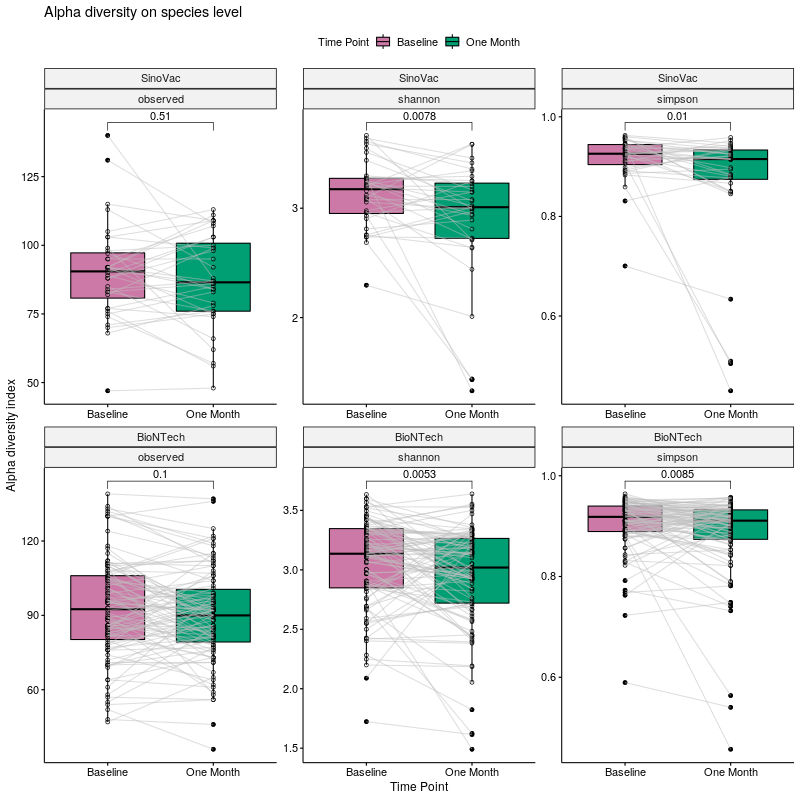

In [31]:
%%R -w 800 -h 800
alpha_diversity_p <- 
    ggboxplot(species_diver_all_l_paired,
              x="TimePoint", y="alpha_diversity_index", fill="TimePoint") +
    #geom_boxplot(aes(fill=TimePoint)) +
    geom_jitter(position = position_jitter(height = 0, width=0), shape = 1) +
    geom_line(aes(group=ID), color="grey", alpha=0.5) +
    facet_wrap(Vac_Group ~ alpha_diversity_method, scales="free") +
    stat_compare_means(comparisons = list(c("D0", "M1")), method = "wilcox.test", paired=T) +
    scale_fill_manual(values = timepoint_color_values,
                      name = "Time Point",
                      breaks=c("D0", "M1"), labels=c("Baseline", "One Month")) +
    scale_x_discrete(labels=c("D0" = "Baseline", "M1" = "One Month")) +
    theme(axis.text.x = element_text(size=11),
          axis.text.y = element_text(size=11)) +
    theme(strip.text.x = element_text(size = 11),
          strip.text.y = element_text(size = 11),
          legend.title = element_text(size = 11,color = "black"),
          legend.text = element_text(size = 11,color = "black")) +
    ggtitle("Alpha diversity on species level") + xlab("Time Point") + ylab("Alpha diversity index")
print(alpha_diversity_p)

ggsave("figures/alpha_diversity/alpha_diversity_species_paired_timepoint.pdf",
       alpha_diversity_p, width=10, height=9)